# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.16 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

single_agent = True
if single_agent:
    # select this option to load version 1 (with a single agent) of the environment
    env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')
else:
    # select this option to load version 2 (with 20 agents) of the environment
    env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.10149999773129821


When finished, you can close the environment.

In [6]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [5]:
from agent import ContinuousControlAgent
from common import *
from collections import deque
from support import Experience, ReplayBuffer
import config
import random
import datetime
from workspace_utils import active_session

In [6]:
def step_tuple(env_info):
    """ Returns a tuple of next state, reward, and done when the agent steps through the environment based
        on the action taken
        :param env_info: Object holding information about the environment at a certain point
    """
    if single_agent:
        return env_info.vector_observations[0], env_info.rewards[0], env_info.local_done[0]
    return env_info.vector_observations, env_info.rewards, env_info.local_done


def plot(stats):
    scores = stats["scores"]
    episodes = stats["episodes"]
    plt.ylabel("Score")
    plt.xlabel("Episode #")
    plt.plot(episodes, scores)
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.show()


def ddpg(agent: ContinuousControlAgent, env: UnityEnvironment, num_episodes=2000, target=30., max_time_steps=500,
         saved_model="checkpoint.pth"):
    """ Train an agent using the DDPG algorithm

        :param agent: a continuous control agent
        :param env: environment the agent interacts with
        :param num_episodes: the number of episodes to train the agent
        :param target: The average target score the agent needs to achieve for optimal performance
        :param max_time_steps: Maximum time steps per episode
        :param saved_model: The file path to save the model weights
    """
    now = datetime.datetime.now()
    print(now, "- Training {}".format("single agent" if single_agent else "{} agents".format(20))
          + " for max {} episodes. Target score to reach is {}".format(num_episodes, target))
    # collections to help keep track of the score
    scores_deque = deque(maxlen=100)
    scores = []
    stats = {"scores": [], "episodes": []}  # collects stats for plotting purposes
    mean_score = 0.

    for episode in range(1, num_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        states = env_info.vector_observations[0] if single_agent else env_info.vector_observations
        agent.reset()                                                # reset the agent noise
        score = 0 if single_agent else np.zeros(num_agents)

        for _ in range(max_time_steps):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states, rewards, dones = step_tuple(env_info)
            if single_agent:
                agent.step(Experience(states, actions, rewards, next_states, dones))
            else:
                for idx in random.sample(range(num_agents), 10):
                    agent.step(Experience(states[idx], actions[idx], rewards[idx], next_states[idx], dones[idx]))
            states = next_states
            score += rewards
            if np.any(dones):
                break
        scores_deque.append(score)
        scores.append(score)
        mean_score = np.mean(scores_deque)

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, mean_score), end="")
        if episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, mean_score))

        stats["scores"].append(score if single_agent else np.mean(score))
        stats["episodes"].append(episode)

        if mean_score >= target:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, mean_score))
            print("Target score of {0} has been reached. Saving model to {1}".format(target, saved_model))
            torch.save(agent.local_actor_network().state_dict(), saved_model)
            break

    now = datetime.datetime.now()
    print(now, "- Finished training " + "successfully!" if mean_score >= target else "unsuccessfully!")
    return scores, stats


def run(agent_: ContinuousControlAgent, env_: UnityEnvironment, num_episodes=2000, max_time_steps=1000, target=30.,
        saved_model="checkpoint.pth"):
    try:
        _, stats = ddpg(agent_, env_, num_episodes=num_episodes, target=target, max_time_steps=max_time_steps,
                        saved_model=saved_model)
        plot(stats)
    finally:
        # make sure the environment gets closed regardless of what happens
        env_.close()


def test(agent_: ContinuousControlAgent, filename):
    agent_.local_actor_network().load_state_dict(torch.load(filename))

    env_info = env.reset(train_mode=False)[brain_name]  # reset the environment
    state = env_info.vector_observations[0] if single_agent else env_info.vector_observations  # get the current state
    score = 0 if single_agent else np.zeros(num_agents)    # initialize the score
    while True:
        action = agent_.act(state, add_noise=False)  # select an action
        env_info = env.step(action)[brain_name]  # send the action to the environment
        next_state = env_info.vector_observations[0] if single_agent else env_info.vector_observations  # get the next state
        reward = env_info.rewards[0] if single_agent else env_info.rewards  # get the reward
        done = env_info.local_done[0] if single_agent else env_info.local_done  # see if episode has finished
        score += reward  # update the score
        state = next_state  # roll over the state to next time step
        if np.any(done):  # exit loop if episode finished
            break

    print("Score: {}".format(score))

    env.close()

Initialised 'Actor: Local' model
Initialised 'Actor: Target' model
Initialised 'Critic: Local' model
Initialised 'Critic: Target' model
2021-03-09 10:54:02.105610 - Training single agent for max 3000 episodes. Target score to reach is 30.0
Agent has not collected enough experiences to start learning. Collected 32, requires at least 128 experiences
Agent has not collected enough experiences to start learning. Collected 64, requires at least 128 experiences
Agent has not collected enough experiences to start learning. Collected 96, requires at least 128 experiences
Agent has not collected enough experiences to start learning. Collected 128, requires at least 128 experiences
Episode 100	Average Score: 2.39
Episode 200	Average Score: 11.02
Episode 300	Average Score: 23.49
Episode 373	Average Score: 30.04
Environment solved in 373 episodes!	Average Score: 30.04
Target score of 30.0 has been reached. Saving model to checkpoint_single.pth
2021-03-09 11:54:36.836158 - Finished training success

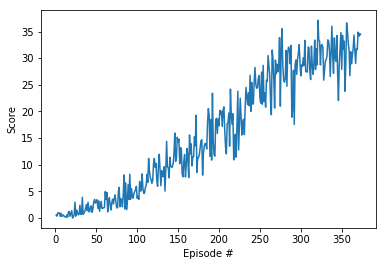

TypeError: 'NoneType' object is not iterable

In [7]:
memory = ReplayBuffer(action_size, config.BUFFER_SIZE, config.BATCH_SIZE, random_seed=0)
agent = ContinuousControlAgent(state_size, action_size, 0, memory=memory, update_frequency=2)
stats = None
saved_model = 'checkpoint_single.pth' if single_agent else 'checkpoint_multi.pth'
with active_session():
    scores, stats = run(agent, env, num_episodes=3000, max_time_steps=1000, target=30., saved_model=saved_model)